# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

2024-06-30 20:25:24.016082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    '''

    images = []
    labels = []
    class_labels = os.listdir(path_to_data)

    for label in class_labels:
        # path to the current label's directory
        label_path = os.path.join(path_to_data, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):

                # construct path to the current label's directory
                image_path = os.path.join(label_path, image_file)

                # load image and convert to array
                image_array = img_to_array(load_img(image_path, target_size=(64, 64)), dtype=int)
                
                # append image and label to respective lists
                images.append(image_array)
                labels.append(label)

    # convert lists to np arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

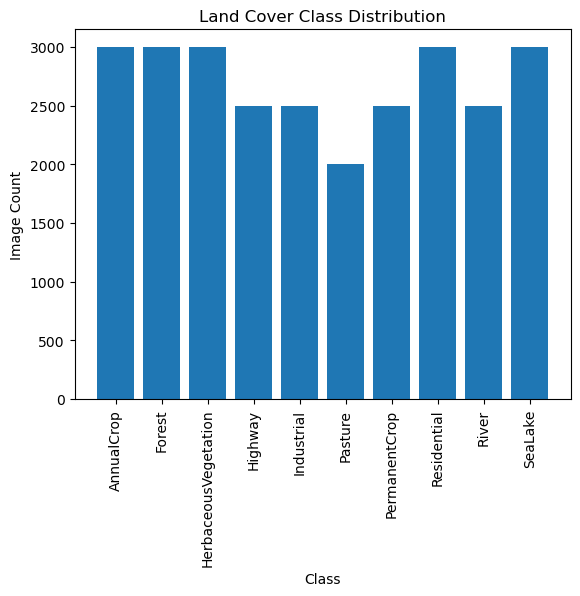

In [4]:
def exercise2():
    data = np.unique(labels, return_counts=True)
    # print(data[0])
    
    plt.bar(x=data[0], height=data[1])
    plt.title("Land Cover Class Distribution")
    plt.xticks(rotation = 90)
    plt.xlabel("Class")
    plt.ylabel("Image Count")
    plt.show()

exercise2()

Comment on class balance: The classes are not balanced. AnnualCrop, Forest, HerbaceousVegetation, Residential, and SeaLake all have 3000 images each but the other 5 do not have as many. Pasture has the least, with only 2,000 images.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

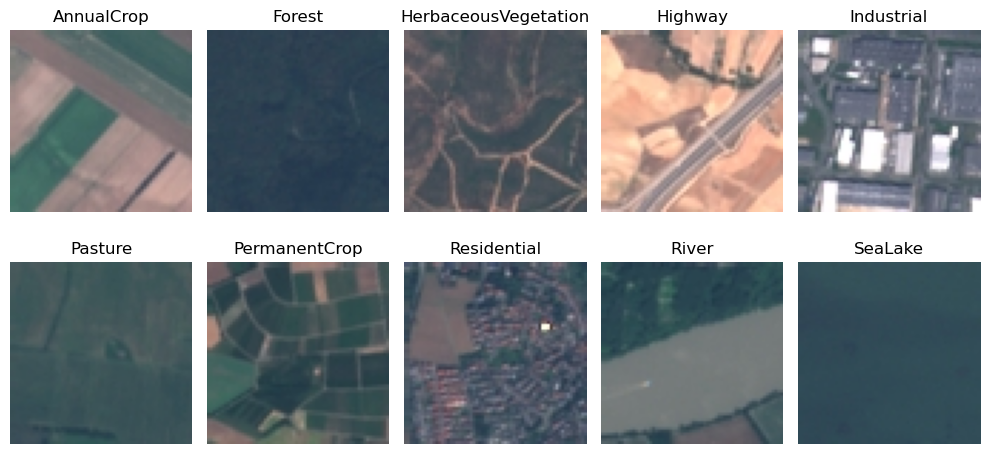

In [5]:
def exercise3(labs, imgs):
    unique_labels = np.unique(labs)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

    for ax, label in zip(axes.flatten(), unique_labels):
        idx = np.where(labs == label)[0][0]
        ax.imshow(imgs[idx].astype('uint8'))
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

exercise3(labels, images)

Most confused land classes: ```AnnualCrop, PermanentCrop```

---
### Step 3: Data preprocessing

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [7]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle the data
    shuffled_indices = np.random.permutation(len(labels))
    shuf_images = images[shuffled_indices]
    shuf_labels = labels[shuffled_indices]

    # create data splits
    if sum(split) == 1.:
        train, test, val = split
    else:
        return "ERROR: split values must be floats that sum to 1"

    # get the total number of examples to be split up
    N = len(labels)

    # indeces on which to split the data into the 3 groups
    split1 = int(N * train) 
    split2 = int(N * (train + test))

    # create train
    X_train = shuf_images[ : split1]
    y_train = shuf_labels[ : split1]

    # create test
    X_test = shuf_images[split1 : split2]
    y_test = shuf_labels[split1 : split2]

    # create val
    X_val = shuf_images[split2 : ]
    y_val = shuf_labels[split2 : ]


    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: 
        - adjust brightness by adding DELTA=0.3 to the pixel values, 
        - then adjust contrast to CONTRAST_FACTOR=3, 
        - then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. 
        - Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [9]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    


    # image augmentation on training data
    if data_partition=="train":
        # create tf tensor from the images array
        X_augm = tf.convert_to_tensor(X, dtype=tf.float32)

        # adjust brightness
        X_augm = tf.image.adjust_brightness(X_augm, delta=DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR)  

        # random flip
        X_augm = tf.image.flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm], axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor


    # rescale image by dividing each pixel by 255.0 
    X = X / 255.

    return X, y

Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): this is important for generalization. It helps the model consider a wider variety of colors and lighting conditions for each label during training without the added cost of collecting more training examples.

The val and test sets are not augmented because when we measure the model's performance, we want to feed real, unaltered images that the model would actually encounter in the real world.

In [10]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [11]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

train accuracy score = 0.4704012345679012
val accuracy score = 0.43666666666666665


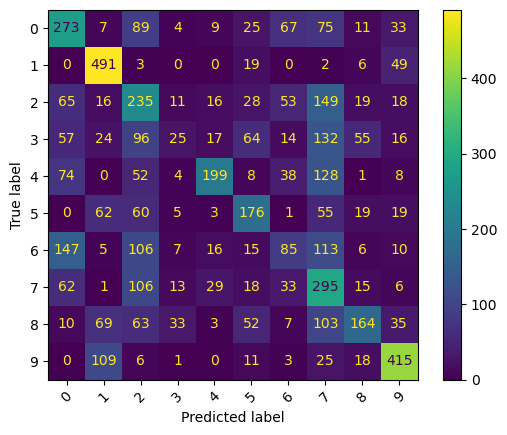

In [12]:
def my_evaluate(model, cm = True):
    y_train_pred = model.predict(X_train_re)
    print("train accuracy score =", accuracy_score(y_train, y_train_pred))

    y_val_pred = model.predict(X_val_re)
    print("val accuracy score =", accuracy_score(y_val, y_val_pred))

    if cm:
        # create and display confusion matrix
        cm = confusion_matrix(y_val, y_val_pred)
        ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_).plot()
        plt.xticks(rotation=45)
        plt.show()

rf_clf = ensemble.RandomForestClassifier(n_estimators=2, n_jobs=1, random_state=7, max_depth=8, verbose=1)
rf_clf.fit(X_train_re, y_train)

my_evaluate(rf_clf)

Comment on model accuracy on training vs. validation data: The model does not perform particularly well on the train data, and the val performance is even worse.

Does the model generalize well?: The val accuracy score is even worse than the train score, suggesting that the model also does not generalize well. 

In [13]:
# get number of tru highway images in y_val data
len(np.where(y_val == 3)[0])

500

In [14]:
# show the encoded labels again
{i: l for i, l in enumerate(encoded_labels_classes)}

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

Comment on the classes that the model confuses the most: 
- label 3 (highway) has the worst overall recall (5%, the model successfully identified 25 / 500 highway images)
- the most frequent incorrect label is True 2 (HerbaceousVegetation) images being incorrectly labeled as a 7 (Residential)
- and when a True 6 (PermanentCrop) is incorrectly labeled as a 0 (AnnualCrop)

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

train accuracy score = 0.713179012345679
val accuracy score = 0.5666666666666667


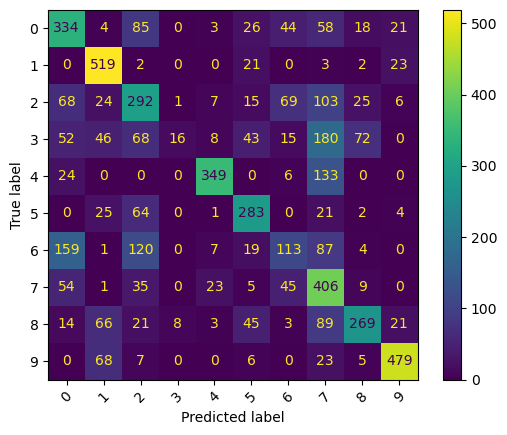

In [15]:
rf_clf2 = ensemble.RandomForestClassifier(n_estimators = 100, max_depth=9, n_jobs = -1, random_state=7)
rf_clf2.fit(X_train_re, y_train)
my_evaluate(rf_clf2)

How your implementation is different compared to the baseline classifier: increased n_estimators to the default 100, increased max_depth from 8 to 9, changed n_jobs from 1 to -1 so that it uses all available CPU power to speed up training. 

Comment on training vs. validation performance relative to baseline model: train score = .71 (a 24% increase from first model) and val score = .56 (a 13% increase from model 1)

Comment on the classes the model confuses the most relative to the baseline: this new model has a better overall accuracy score, but it is even worse at correctly identifying the highway class (3) performs even worse on 

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

test accuracy score = 0.5674074074074074


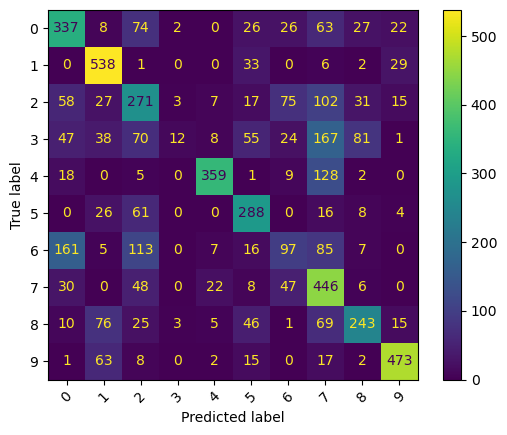

In [16]:
def exercise8():
    y_test_pred = rf_clf2.predict(X_test_re)
    print("test accuracy score =", accuracy_score(y_test, y_test_pred))

    # create and display confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_clf2.classes_).plot()
    plt.xticks(rotation=45)
    plt.show()

exercise8()

Comment on test set accuracy vs. training vs. validation set accuracy: the test accuracy score of 0.56 is similar to the val accuracy, suggesting that this model has decent generalization at least compared to the validation set. however, accuracy of 0.56 is still low and there is much room for improvement. 

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

In [17]:
### YOUR ANSWER HERE ###
""" 
Decision Forests are a good starting point for this land cover classification task. They are quick to train, easily interpretable, and less prone 
to overfitting than some other model frameworks, but it seems like there may be other ML techinques that would perform better. 
"""


' \nDecision Forests are a good starting point for this land cover classification task. They are quick to train, easily interpretable, and less prone \nto overfitting than some other model frameworks, but it seems like there may be other ML techinques that would perform better. \n'

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

In [18]:
### YOUR ANSWER HERE ###

# A neural network will likely outperfome the Decision Forest Classifier because it can do a better job of encoding the relationship between pixels than the Decision Forest Classifier. 
# Specifically, a convolutional neural network is typically used for difficult image classification tasks like this one because it focuses in on the relationships between neighboring pixels. 

---
#### <span style="color:chocolate"> Bonus question (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?